In [18]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
#load in the data set
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print ('Data Types:')
print (data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
Data Types:
Month          object
#Passengers     int64
dtype: object


In [6]:
#read the data as a time series
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = 'Month', date_parser=dateparse)
print ('Parsed Data:')
data.head()

Parsed Data:


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [120]:
#convert to series to make indexing easier
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [16]:
#only works correctly if the dates are sorted
test = ts['1949-01-01': '1949-05-01']
print(test)

test2 = ts['1949']
print(test2)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64


In [49]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [62]:
#set some plotting parameters
sns.set()
sns.set_palette("husl")
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

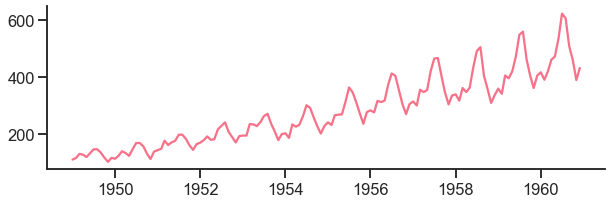

In [102]:
#plot the raw data
plt.figure(figsize=(10,3))
sns.lineplot(data =ts)
sns.despine()

In [133]:
#a function to take time series at input and generate rolling statitics and the dickey-fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = sns.lineplot(data = timeseries,label='Original')
    mean = sns.lineplot(data = rolmean,  label='Rolling Mean')
    std = sns.lineplot(data = rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

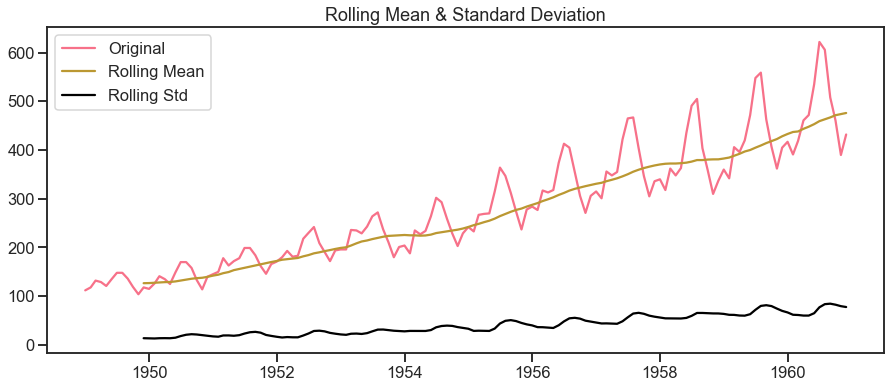

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [134]:
test_stationarity(ts)

#this time series is clearly not stationary-- number of passengers grows over time and we see seasonality

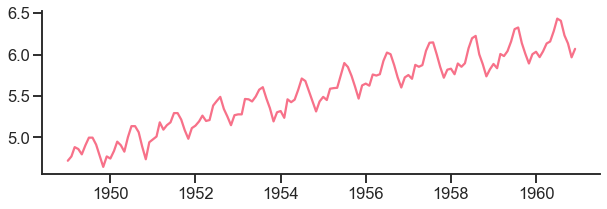

In [114]:
#we want to estimate and eliminate the trend
#first do a log transform
ts_log = np.log(ts)
plt.figure(figsize=(10,3))
sns.lineplot(data = ts_log)
sns.despine()

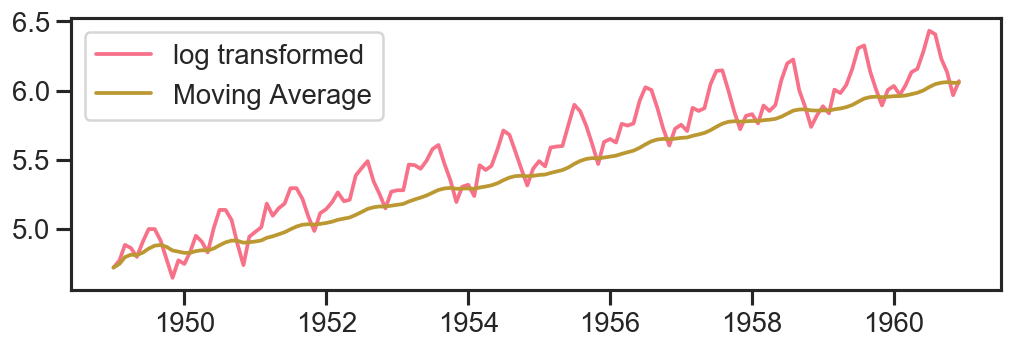

In [260]:
#do a moving average to smooth the data-- use an expoential weighted moving average
moving_avg = ts_log.ewm(halflife = 12).mean()
plt.figure(figsize=(10,3))
logT = sns.lineplot(data = ts_log, label='log transformed')
mvgAvg = sns.lineplot(data = moving_avg, label='Moving Average')
plt.legend(loc='best')

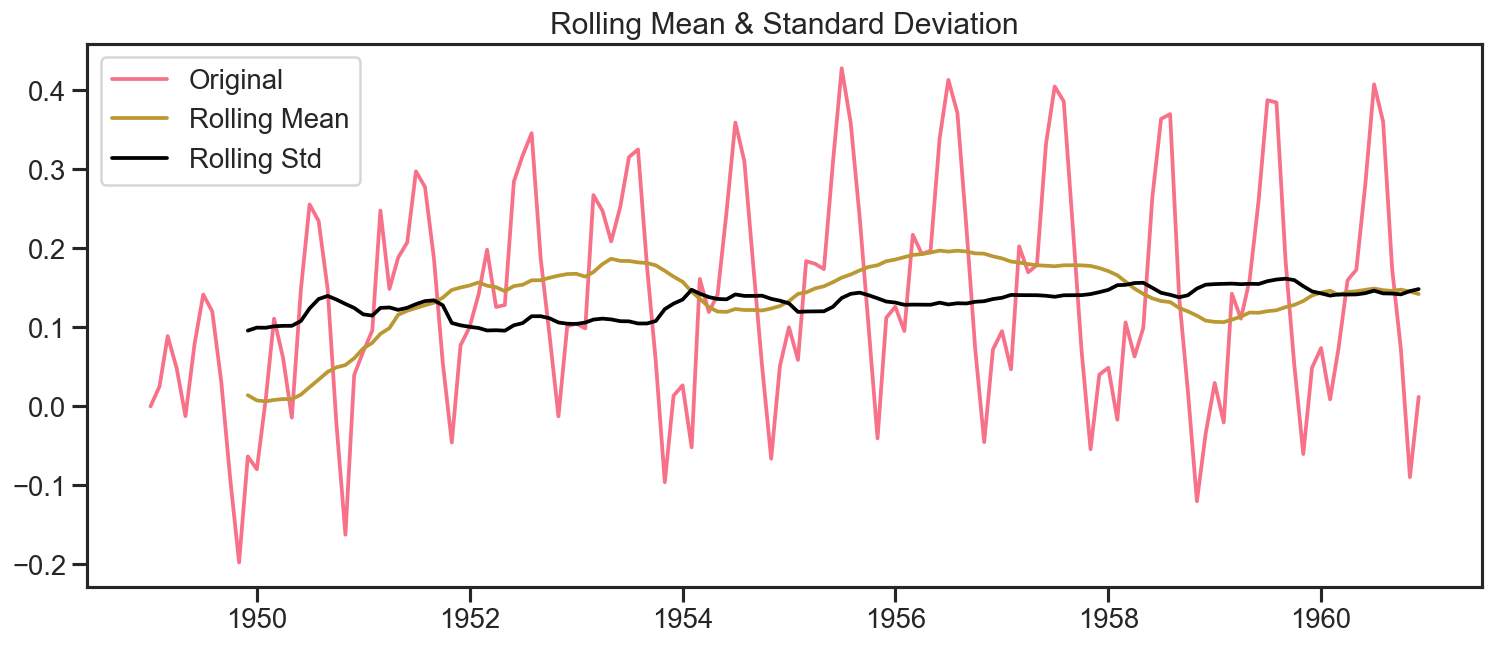

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [261]:
ts_log_moving_avg_diff = ts_log - moving_avg #subtract the moving average from the log transformed data
ts_log_moving_avg_diff.dropna(inplace=True) #drop the first 11 values since they're not included in the moving avg
test_stationarity(ts_log_moving_avg_diff) #test stationarity- it's stationary! less than 1% critical value

Subtracting the exponential moving average works pretty well!

# Try this with a different trend/seasonality removal method
Differencing

In [218]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

First, try to figure out how much differencing we need

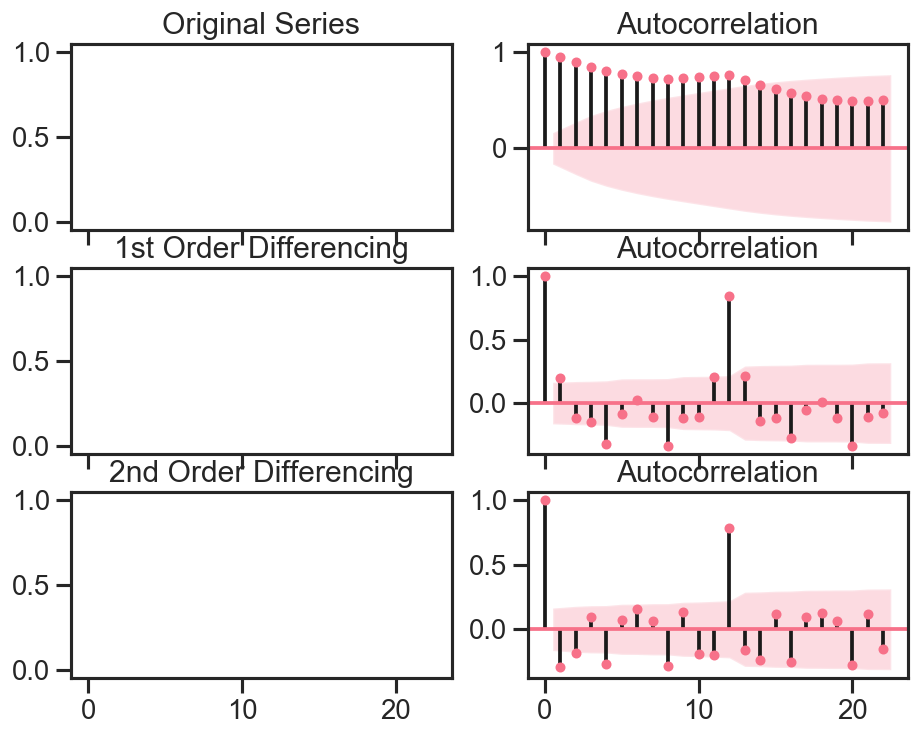

In [236]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0,0].plot(data = ts_log)
axes[0,0].set_title('Original Series')
plot_acf(ts_log, ax=axes[0,1])

# 1st Differencing
axes[1,0].plot(data = ts_log.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(ts_log.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2,0].plot(data = ts_log.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(ts_log.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

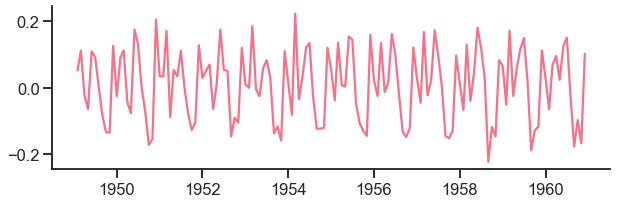

In [115]:
#we want to estimate and eliminate the trend
#first do a log transform then perform differencing
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(10,3))
sns.lineplot(data = ts_log_diff)
sns.despine()

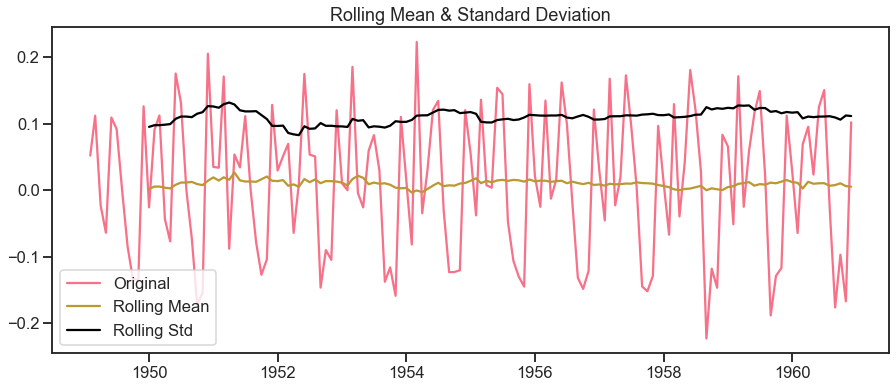

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [136]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff) #not great- only less than 10%

Differencing was just okay

# Try this with a different trend/seasonality removal method
Decomposition

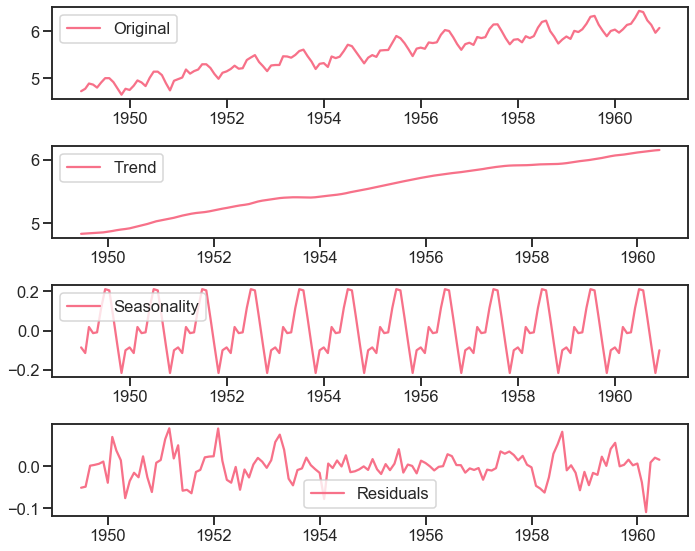

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

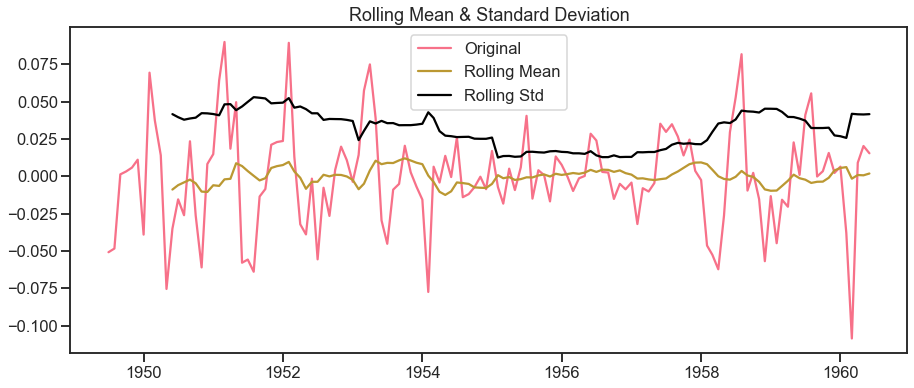

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [188]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Decomposition worked very well!

# Move onto forecasting with this data

Try Auto-Regressive Integrated Moving Averages (ARIMA)

In [138]:
from statsmodels.tsa.stattools import acf, pacf

In [211]:
lag_acf = acf(ts_log_moving_avg_diff, nlags=20)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=20, method = 'ols')

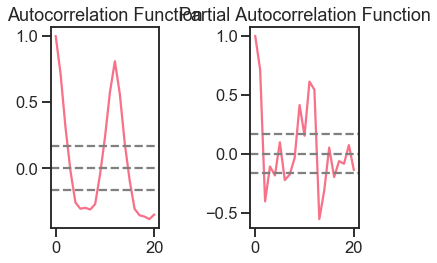

In [212]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [170]:
print(lag_acf), print(lag_pacf)

[ 1.          0.19975134 -0.12010433 -0.15077204 -0.32207432 -0.08397453
  0.02577843 -0.11096075 -0.33672146 -0.11558631 -0.10926704  0.20585223
  0.84142998  0.21508704 -0.13955394 -0.11599576 -0.27894284 -0.05170646
  0.01245814 -0.1143576  -0.33717439]
[ 1.          0.20081508 -0.17368194 -0.09901213 -0.33527437  0.00872185
 -0.07990745 -0.21923579 -0.5421352  -0.22848913 -0.64775301 -0.53828661
  0.59971786  0.29995642 -0.10992268  0.14878637 -0.00321881  0.01892684
 -0.14268478  0.07089814 -0.15566902]


(None, None)

p=2 and q=2 (the first point where the values is greater than the upper CI line

In [205]:
from statsmodels.tsa.arima_model import ARIMA

In [206]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                     ARMA(2, 1)   Log Likelihood                 149.738
Method:                       css-mle   S.D. of innovations              0.085
Date:                Thu, 12 Sep 2019   AIC                           -289.475
Time:                        14:35:25   BIC                           -274.626
Sample:                    01-01-1949   HQIC                          -283.441
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1361      0.013     10.693      0.000       0.111       0.161
ar.L1.#Passengers     1.3915      0.120     11.624      0.000       1.157       1.626
ar.L2.#Passengers    -0.

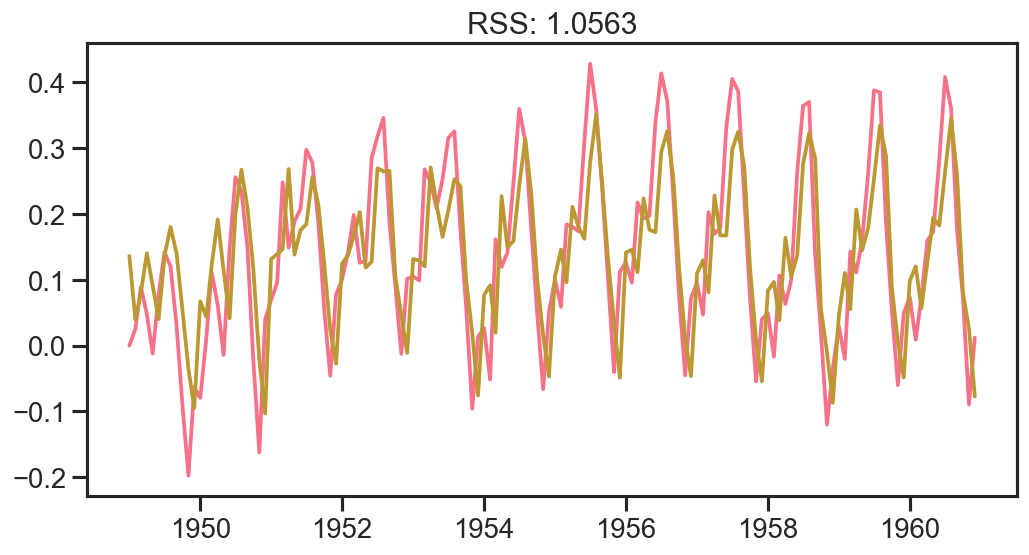

In [252]:
model = ARIMA(ts_log_moving_avg_diff, order=(2,0,1))
results_ARIMA = model.fit(disp=0)
plt.figure(figsize=(10,5))
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues)
results_ARIMA.fittedvalues = np.ravel(results_ARIMA.fittedvalues)
ts2 = np.ravel(ts_log_moving_avg_diff)
#ts2 = ts2[:143]
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts2)**2))
print(results_ARIMA.summary())


                0
count  144.000000
mean    -0.000473
std      0.085946
min     -0.162677
25%     -0.062005
50%     -0.012829
75%      0.081686
max      0.166897


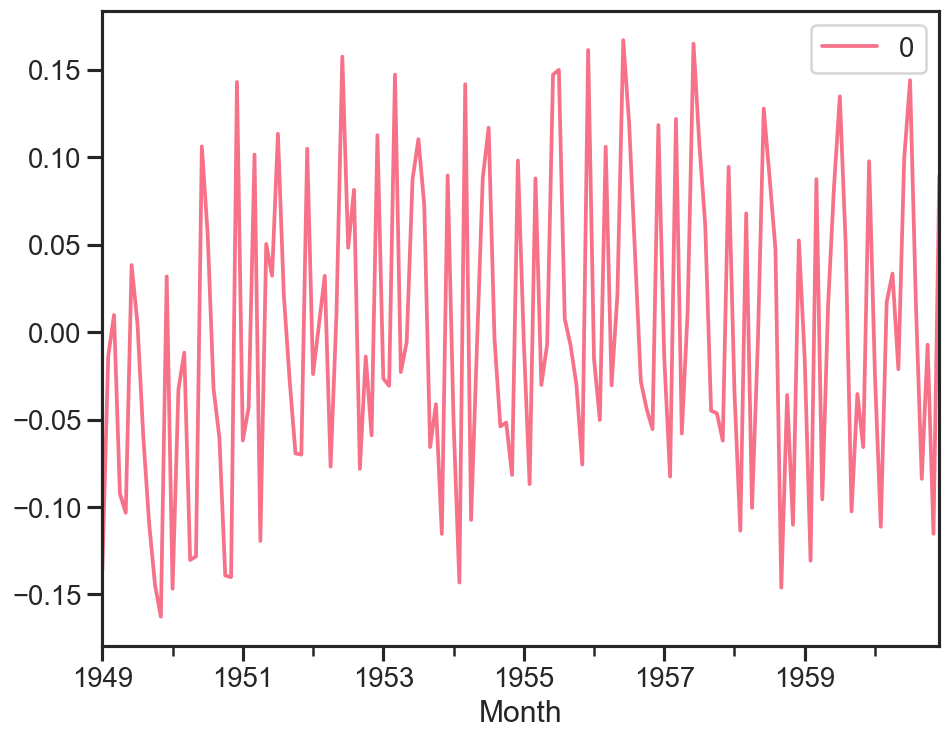

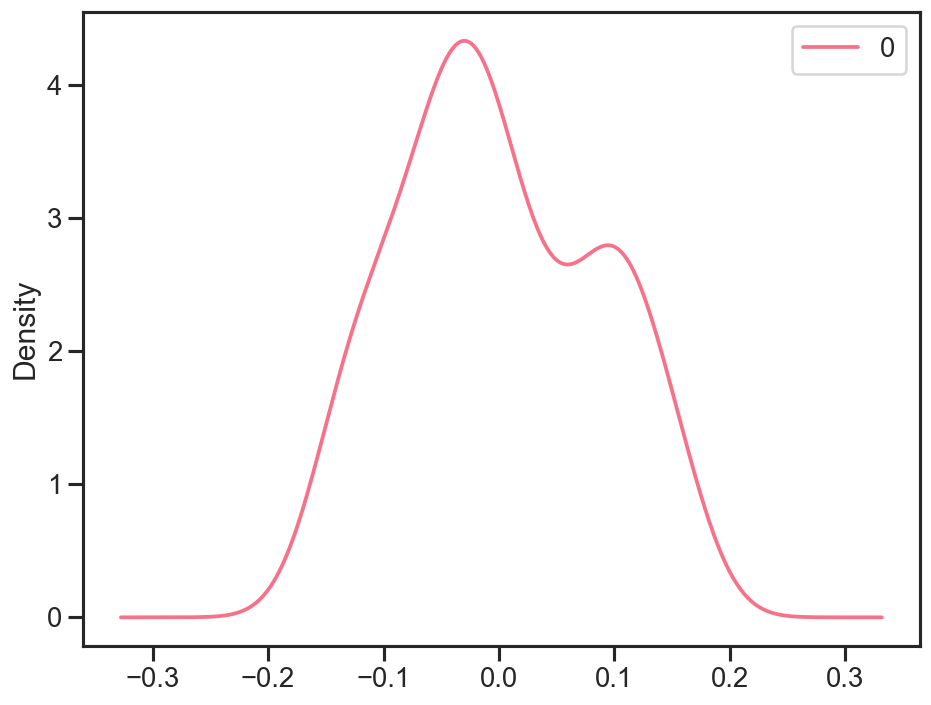

In [254]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

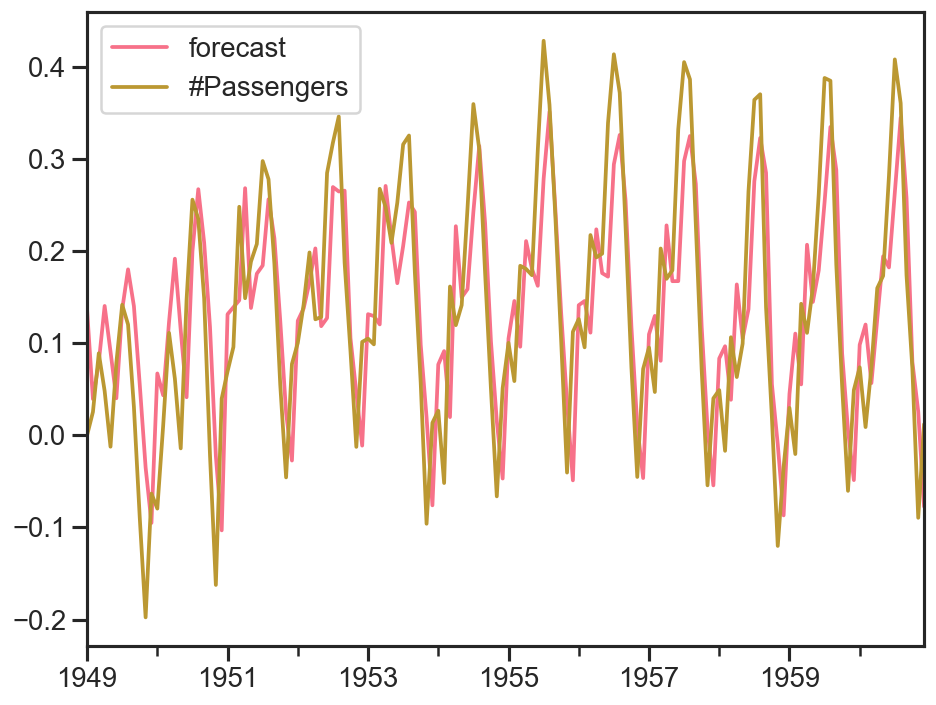

In [255]:
results_ARIMA.plot_predict(dynamic=False)
plt.show()

use out of time cross validation to find optimal ARIMA model

In [ ]:
from statsmodels.tsa.stattools import acf

#Create training and test sets
train = ts[]